# Prelude

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas
import numpy
import itertools
import matplotlib
import seaborn
import textwrap

from matplotlib.ticker import *

from matplotlib import pyplot
from matplotlib.ticker import FixedLocator, AutoLocator, FuncFormatter, MultipleLocator, IndexLocator, MaxNLocator

from pandas import Series, DataFrame, Index

seaborn.set()

In [2]:
from scipy import stats

# Getting Data

In [3]:
llama = pandas.read_csv('outputs/llama.csv', index_col = 'Num')
llama.name = 'llama-3.1-8B'

bigllama = pandas.read_csv('outputs/llama-70b.csv', index_col = 'Num').rename(columns = lambda x: x.split('-')[0])
bigllama.name = 'llama-3.1-70B'

In [4]:
flan = pandas.read_csv('outputs/flan-t5-xl.csv', index_col = 'Num')
flan.name = 'flan-t5-xl'

bigflan = pandas.read_csv('outputs/flan-t5-xxl.csv', index_col = 'Num')
bigflan.name = 'flan-t5-xxl'

# Plotting Functions

In [5]:
def cool_line(left, right, ax = None, cleft = None, cright = None, **kwargs):
    if ax is None:
        ax = pyplot.gca()

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['[]', '[ctx]'])
    # ax.set_ylim(0 - .05, 1 + .05)

    kwargs['alpha'] = .75
    kwargs['color'] = cleft or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([0], [left], **kwargs)

    kwargs['color'] = cright or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([1], [right], **kwargs)

    kwargs['color'] = 'black'
    kwargs['alpha'] = 1
    kwargs['linewidth'] = .2
    kwargs['zorder'] = 1
    ax.plot([0, 1], [left, right], **kwargs)

In [64]:
palette = seaborn.color_palette('hls', 3)
colors = {
    'Parametric': palette[1],
    'Contextual': palette[0],
    'Other': palette[2],
}
zorders = {
    colors['Parametric']: 5,
    colors['Contextual']: 4,
    colors['Other']: 6,
}

pcolors = {
    'Parametric': palette[1],
    'Contextual': palette[0],
}

dark_palette = seaborn.color_palette('dark', 3)
dark_colors = {
    'Parametric': dark_palette[2],
    'Contextual': dark_palette[1],
    'Other': dark_palette[0],
}
dark_pcolors = {
    'Parametric': dark_palette[2],
    'Contextual': dark_palette[1],
}

all_colors = [colors, dark_colors]
all_pcolors = [pcolors, dark_pcolors]

def getPlots(table, title = None, axs = None):
    if axs is None:
        fig, axs = pyplot.subplots(
            ncols = 3,
            squeeze = True,
            sharey = True,
        )
        if title:
            fig.suptitle(title, fontsize = 12)

    top = 0
    bot = 100

    for _, row in table.iterrows():
        cright = colors[row.comparison]

        base_proba = row.base_proba
        base_cf_proba = row.base_cf_proba
        ctx_proba = row.ctx_proba
        ctx_param_proba = row.ctx_param_proba
        ctx_cf_proba = row.ctx_cf_proba

        cool_line(base_proba, ctx_param_proba, axs[0], color = colors['Parametric'])
        # cool_line(base_proba, ctx_proba, axs[1], cleft = colors['Parametric'], cright = cright)
        cool_line(base_cf_proba, ctx_cf_proba, axs[1], color = colors['Counterfactual'])

        filt = lambda p: filter(lambda x: x < 100, p)
        top = max(top, *filt([base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba]))
        bot = min(bot, *filt([base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba]))

    axs[0].set_ylabel('Cross-Entropy', fontsize = 9)
    axs[0].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    axs[1].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    # for ax in axs:
        # ax.set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)

In [7]:
def barTable(*tables, names = None):
    if names is None:
        names = [t.name for t in tables]
    assert len(names) == len(tables)

    datas = []
    for e, (t, n) in enumerate(zip(tables, names)):
        datas.append(Series(
            {x: sum(t.comparison == x) for x in colors.keys()},
            name = n,
        ))

    return pandas.concat(datas, axis = 1).T

def barPlot(*tables, ax = None, names = None, percent = False, show_ylabel = True):
    if ax is None:
        pyplot.figure()
        ax = pyplot.gca()

    if names is None:
        names = [t.name for t in tables]
    assert len(names) == len(tables)

    tab = .8 * (1 / len(tables))
    for e, (t, n) in enumerate(zip(tables, names)):
        data = [sum(t.comparison == x) for x in colors.keys()]
        if percent:
            data = [x / t.index.size for x in data]

        ax.bar(
            [x + e * tab for x in range(3)],
            data,
            width = tab,
            align = 'edge',
            color = all_colors[e].values(),
            tick_label = colors.keys(),
            label = [n, ' ', ' '],
        )

    if percent:
        # ax.set_ylabel('Ratio of results')
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
        ax.tick_params(axis='both', which='major', labelsize = 9, pad = -3)
    else:
        if show_ylabel:
            ax.set_ylabel('Resulting Entries', fontsize = 10)
        ax.tick_params(axis='both', which='major', labelsize = 10, pad = -3)
        ax.set_ylim(0, tables[0].shape[0])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles[0::3] + handles[1::3] + handles[2::3],
            labels[0::3] + labels[1::3] + labels[2::3],
            ncols = 3,
            fontsize = 'small',
            markerfirst = False,
            columnspacing = 0,
        )


In [72]:
def boxTable(*tables, names = None, percent = False):
    if names is None:
        names = [t.name for t in tables]
    assert(len(names) == len(tables))

    results = []
    for e, (t, n) in enumerate(zip(tables, names)):
        to_drop = ['min', 'max']
        results.append(
            t \
            .groupby('comparison') \
            .ctx_proba \
            .describe() \
            .T \
            .drop(to_drop, axis = 0),
        )

    return pandas.concat(results, keys = names, axis = 1)

def boxPlot(*tables, ax = None, names = None, percent = None):
    if ax is None:
        pyplot.figure()
        ax = pyplot.gca()

    if names is None:
        names = [t.name for t in tables]
    assert(len(names) == len(tables))

    tab = .8 * (1 / len(tables))
    for e, (t, n) in enumerate(zip(tables, names)):
        plot = ax.boxplot(
            [t[t.comparison == x].ctx_proba for x in pcolors.keys()],
            positions = [x + e * tab for x in range(2)],
            widths = tab,
            showfliers = False,
            patch_artist = True,
            label = [n, ' '],
        )
        for p, c in zip(plot['boxes'], all_pcolors[e].values()):
            p.set_facecolor(c)

    ax.set_ylabel('Perplexity', fontsize = 9)
    # ax.set_ylim(.25, None)
    ax.set_xticks([x + 1/4 * len(tables) * tab for x in range(2)], labels = pcolors.keys())

    ax.yaxis.set_major_locator(MaxNLocator(5, min_n_ticks = 5))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

    if percent:
        ax.tick_params(axis='both', which='major', labelsize = 9, pad = -3)

    handles, labels = pyplot.gca().get_legend_handles_labels()
    ax.legend(
        handles[0::2] + handles[1::2],
        labels[0::2] + labels[1::2],
        ncols = 2,
        fontsize = 'x-small',
        markerfirst = False,
        columnspacing = 0,
    )

In [9]:
def avgPlots(table):
    for e, (k, v) in enumerate(colors.items()):
        p = llama[llama.comparison == k].groupby('Category').ctx_proba.mean().sort_index()
        pyplot.bar(
            [e * (p.shape[0] + 1) + x for x in range(p.shape[0])],
            p,
            color = v,
            align = 'edge',
            width = 1,
        )

In [10]:
def generateTables(*tables, head = None):
    for question, table in itertools.islice(tables[0].groupby('Base_Question'), head):
        ix = table.index

        fig, axs = pyplot.subplots(ncols = 4, nrows = len(tables), width_ratios = [1, 1, 1.5, 2], squeeze = False, figsize = (10, 3 * len(tables)))
        fig.tight_layout(rect = [0, .05, 1, .97])
        fig.suptitle(question, fontsize = 12)

        for e, df in enumerate(tables):
            df_part = df.loc[ix]
            getPlots(df_part, axs = axs[e][0:2])
            boxPlot(df_part, ax = axs[e][2])
            barPlot(df_part, ax = axs[e][3])

        for name, color in colors.items():
            pyplot.scatter([], [], label = name, color = color)

        pyplot.legend(ncols = 3, bbox_to_anchor = [0, -.2])
        pyplot.show()

In [85]:
def cat_subplots(*tables, table_func, plot_func):
    fig, axs = pyplot.subplots(
        5,
        2,
        figsize = (2 * 4, 5 * 2.2),
        sharey = True,
    )
    axs = list(itertools.chain.from_iterable(axs))

    results = []
    for cat, ax in zip(tables[0].Category.unique(), axs):
        thiscat = [
            t[t.Category == cat]
            for t in tables
        ]
        names = [t.name for t in tables]

        if table_func is not None:
            results.append(table_func(*thiscat, names = names).stack().rename(cat))

        plot_func(
            *thiscat,
            names = names,
            ax = ax,
            percent = True,
        )
        ax.set_title(cat.title().replace('_', ' '), fontsize = 10, fontweight = 'bold', pad = 3)

        ax.tick_params(axis = 'y', labelleft = True)

    fig.delaxes(axs[9])
    handles, labels = axs[0].get_legend_handles_labels()
    n = len(handles) // 2
    fig.legend(
        handles[0::n] + handles[1::n],
        labels[0::n] + labels[1::n],
        ncols = n,
        markerfirst = False,
        columnspacing = 0,
        loc = 'lower right',
        bbox_to_anchor = (.89, .13),
        title = 'Models',
    )
    pyplot.subplots_adjust(hspace = .32)

    if results:
        display(pandas.concat(results, axis = 1).T)


# Plotting Data

## Amount barplots

In [11]:
matplotlib.rcParams['figure.figsize'] = 5, 3

,Parametric,Contextual,Other
llama-3.1-8B,745,3662,353
llama-3.1-70B,1070,3303,387


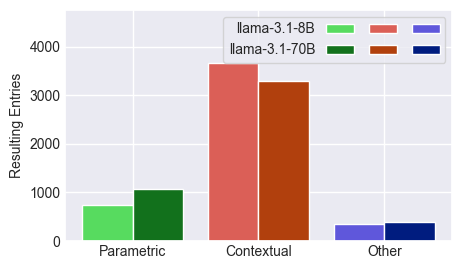

In [12]:
display(barTable(llama, bigllama))
barPlot(llama, bigllama)
pyplot.savefig('Report/figures/llama_amount.png', dpi = 200, bbox_inches = 'tight')

,Parametric,Contextual,Other
flan-t5-xl,248,4284,228
flan-t5-xxl,242,4304,214


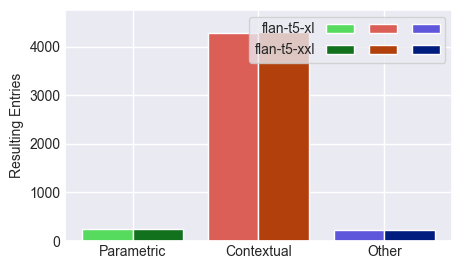

In [13]:
display(barTable(flan, bigflan))
barPlot(flan, bigflan)
pyplot.savefig('Report/figures/flan_amount.png', dpi = 200, bbox_inches = 'tight')

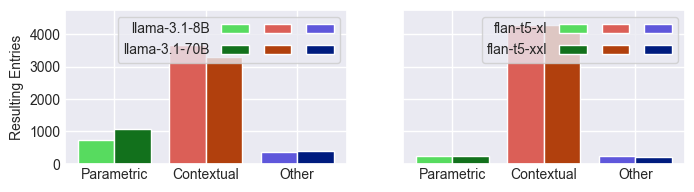

In [14]:
fig, axs = pyplot.subplots(1, 2, figsize = (8, 2), squeeze = True, sharey = True)
barPlot(llama, bigllama, ax = axs[0])
barPlot(flan, bigflan, ax = axs[1], show_ylabel = False)
pyplot.savefig('Report/figures/both_amount.png', dpi = 200, bbox_inches = 'tight')

llama-3.1-8B                  llama-3.1-70B                 
                   Parametric Contextual Other    Parametric Contextual Other
person                     40        833    96           209        614   146
city                      117       1007    66           166        966    58
principle                  44        118    23            44        117    24
element                   218        385    42           275        347    23
book                      135        344    60           154        318    67
painting                   47        458    23            49        445    34
historical_event           81        154    21           117        118    21
building                   27        163     8            31        159     8
composition                36        200    14            25        219     6

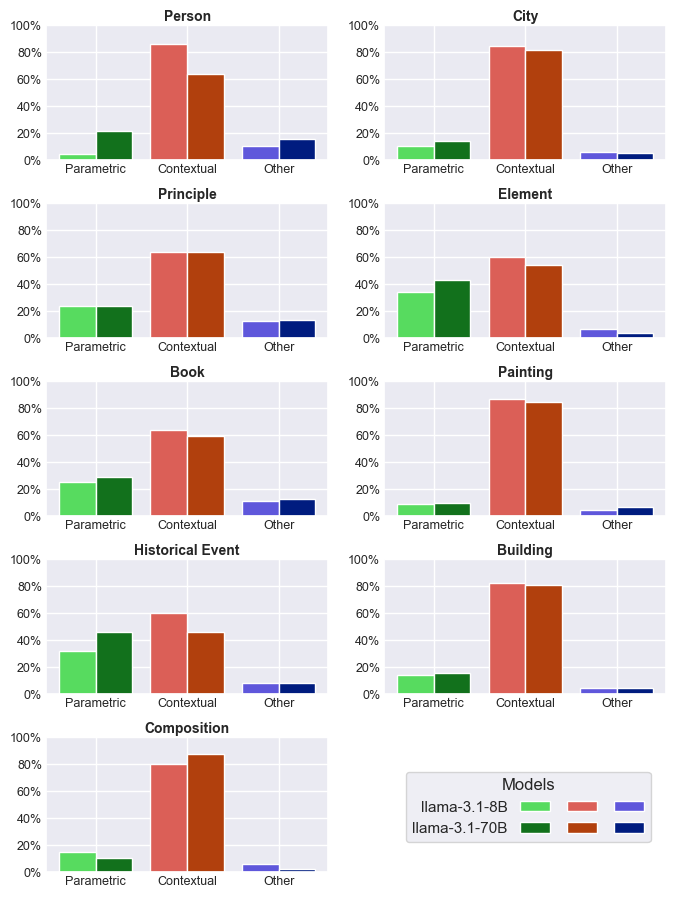

In [27]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(llama, bigllama, table_func = barTable, plot_func = barPlot)
pyplot.savefig('Report/figures/llama_allcats.png', dpi = 200, bbox_inches = 'tight')

flan-t5-xl                  flan-t5-xxl                 
                 Parametric Contextual Other  Parametric Contextual Other
person                   32        900    37          23        890    56
city                    120       1030    40          78       1093    19
principle                13        164     8           9        168     8
element                   6        637     2         102        515    28
book                     26        488    25          18        457    64
painting                 26        446    56           4        498    26
historical_event         11        217    28           1        254     1
building                 14        174    10           0        189     9
composition               0        228    22           7        240     3

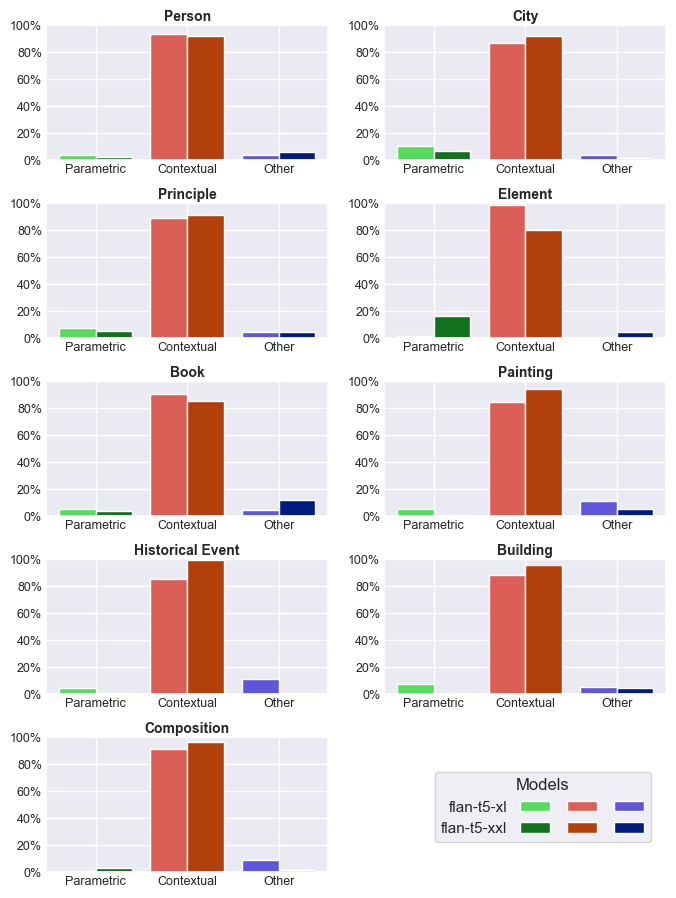

In [29]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(flan, bigflan, table_func = barTable, plot_func = barPlot)
pyplot.savefig('Report/figures/flan_allcats.png', dpi = 200, bbox_inches = 'tight')

In [17]:
display(boxTable(llama, bigllama))
display(boxTable(flan, bigflan))

llama-3.1-8B                         llama-3.1-70B              \
comparison   Contextual       Other  Parametric    Contextual       Other   
count       3662.000000  353.000000  745.000000   3303.000000  387.000000   
mean           1.166749    1.636585    1.342487      1.185168    1.450267   
std            0.239526    0.776940    0.353650      0.270600    0.539657   
25%            1.046211    1.242027    1.133281      1.057964    1.176173   
50%            1.091271    1.392295    1.237821      1.102173    1.299078   
75%            1.186070    1.681327    1.436452      1.207113    1.463195   

                         
comparison   Parametric  
count       1070.000000  
mean           1.389097  
std            0.380201  
25%            1.145459  
50%            1.262679  
75%            1.504494

flan-t5-xl                          flan-t5-xxl              \
comparison   Contextual       Other  Parametric   Contextual       Other   
count       4284.000000  228.000000  248.000000  4304.000000  214.000000   
mean           1.900861    6.449082    2.413495     1.932615    3.489157   
std            1.533569   12.447835    1.061862     5.612787    6.500357   
25%            1.210938    2.558594    1.500000     1.023438    1.220703   
50%            1.414062    3.390625    2.296875     1.093750    1.937500   
75%            1.853516    6.976562    3.156250     1.289062    3.308594   

                        
comparison  Parametric  
count       242.000000  
mean         10.317472  
std          16.992694  
25%           1.109375  
50%           1.527344  
75%           7.218750

## Boxplots

In [21]:
matplotlib.rcParams['figure.figsize'] = 5, 3

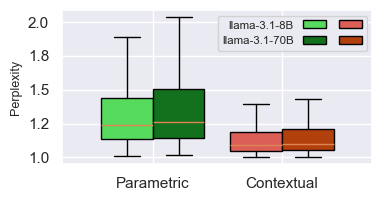

In [73]:
boxPlot(llama, bigllama)
pyplot.savefig('Report/figures/llama_boxplot.png', dpi = 200, bbox_inches = 'tight')

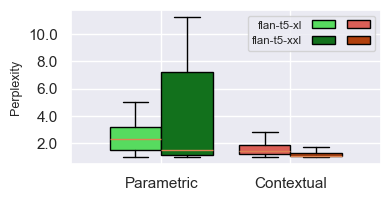

In [74]:
boxPlot(flan, bigflan)
pyplot.savefig('Report/figures/flan_boxplot.png', dpi = 200, bbox_inches = 'tight')

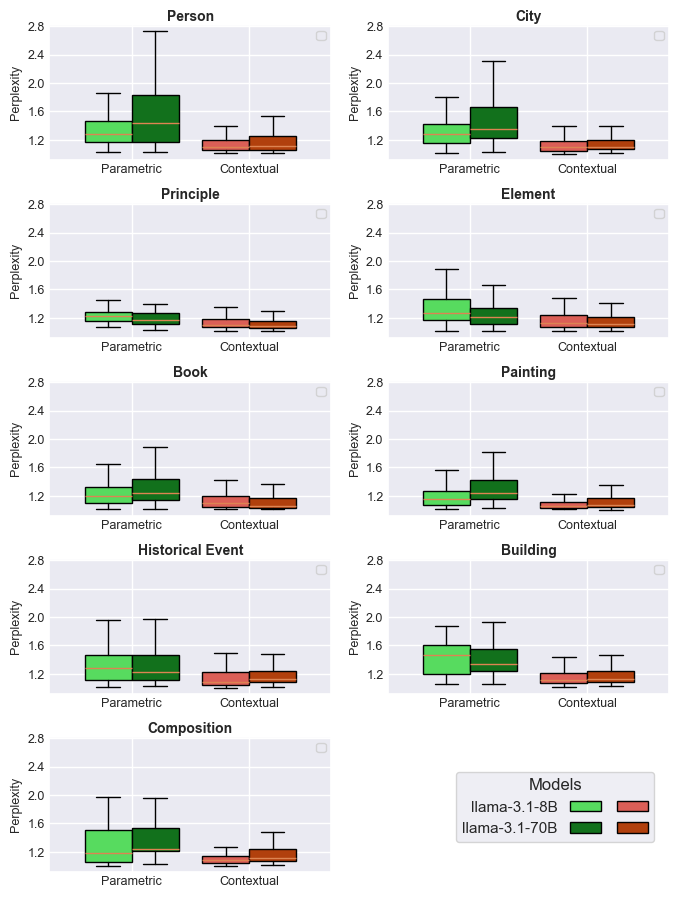

In [86]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(llama, bigllama, table_func = None, plot_func = boxPlot)
pyplot.savefig('Report/figures/llama_catboxes.png', dpi = 200, bbox_inches = 'tight')

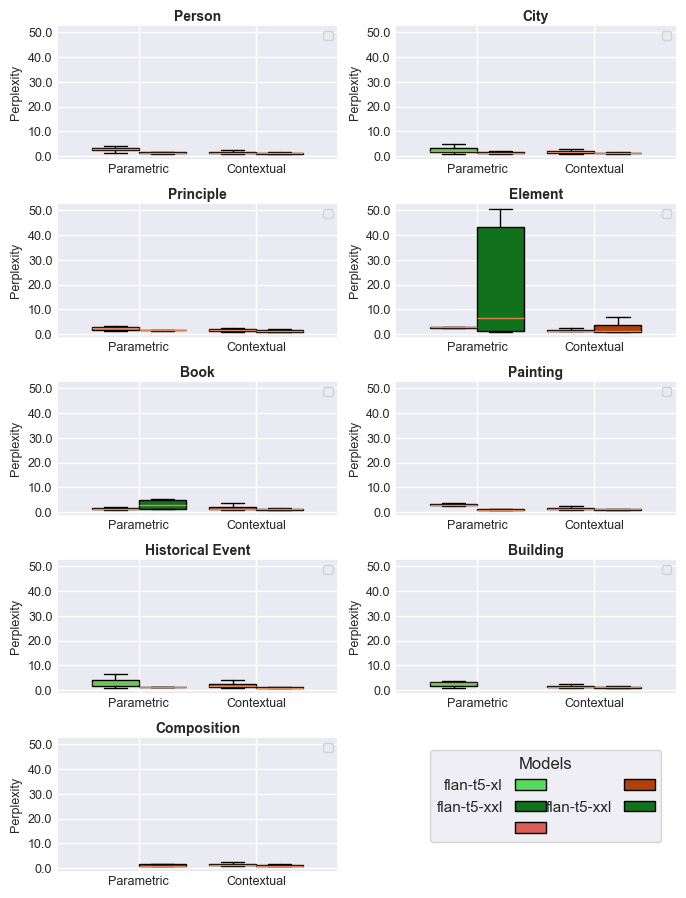

In [84]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(flan, bigflan, table_func = None, plot_func = boxPlot)
pyplot.savefig('Report/figures/flan_catboxes.png', dpi = 200, bbox_inches = 'tight')